In [1]:
# On importe notre librairie de pré-traitement
import os
import sys
sys.path.append(os.path.dirname( os.path.dirname( os.path.abspath('dionysos') ) ) )
from prevision.xg_model import *

# Pre-processing

On importe les données sur les ventes, la méteo et les attendance des évenements autours de la cage aux sports. On crée ensuite un dictionnaire. On note alors:

* X les variables d'entrée de notre modèle
* y la variable de sortie de notre modèle


In [2]:
chemin_fichier_csv = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('dionysos'))),'prevision', 'data')
X,y = pre_process.get_data(big_chemin = chemin_fichier_csv + '/')

# on affiche les 5 premières lignes de notre dataset
print(X.head())
print("\n")
# on affiche les 5 premières lignes de notre target
print(y.head())


   attendance  prevision  apparent_temperature_mean (°C)  rain_sum (mm)  \
3     18692.0     9000.0                            -7.5            0.0   
4     43576.0    14000.0                           -10.0            0.1   
5     29462.0    16000.0                            -7.5            0.0   
6     74643.0    22000.0                            -5.9            0.0   
7     69394.0    20000.0                            -8.2            0.0   

   snowfall_sum (cm)  day_0  day_1  day_2  day_3  day_4  day_5  day_6  
3               0.00      1      0      0      0      0      0      0  
4               1.47      0      1      0      0      0      0      0  
5               0.00      0      0      1      0      0      0      0  
6               0.00      0      0      0      1      0      0      0  
7               0.00      0      0      0      0      1      0      0  


3     7142.63
4    13997.38
5    18136.16
6    19975.51
7    18626.76
Name: vente, dtype: float64


On remarque que les prévisions sont dans les valeurs X mais elle ne seront pas prise en compte par la suite dans notre modèle. On split ensuite nos données en données d'entrainement et de test en récuperant les previsions de la cage actuelle qui seront utilisées pour tester notre modèle.

In [3]:
X_train, X_test, y_train, y_test, prevision_cage = pre_process.split(X, y,random_state = 42)

# Modèle

## Modèle Xg Boost 

On utilise un modèle xg Boost pour prédire les ventes de la cage aux sports. On utilise une cross validation (Random search) pour trouver les meilleurs hyper-paramètres du modèle. On utilise ensuite ces hyper-paramètres pour entrainer notre modèle sur les données d'entrainement. On affiche ensuite les résultats de notre modèle sur les données de test.

### Hyper-paramètres




INFO:root:[05/06/2023 05:05:33] Recherche des meilleurs hyperparamètres


Fitting 5 folds for each of 20 candidates, totalling 100 fits


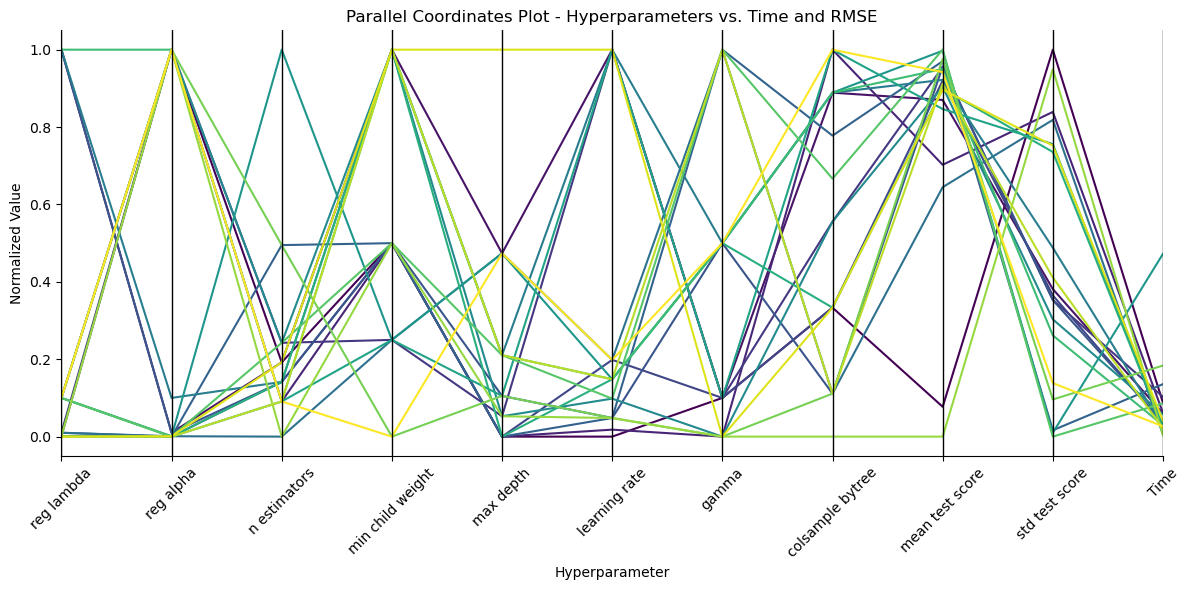

Meilleurs hyperparamètres : {'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 250, 'min_child_weight': 3, 'max_depth': 25, 'learning_rate': 0.05, 'gamma': 1.0, 'colsample_bytree': 0.7}
RMSE : 3189.297906559785


In [4]:
lg.info("[" + str(datetime.now().strftime("%d/%m/%Y %H:%M:%S")) + "] Recherche des meilleurs hyperparamètres")
best_params, best_model = modele_xg.hyperparametres_random(X_train, y_train, X_test, y_test,plot = True,param = 'MSE')
best_params, best_model = modele_xg.hyperparametres_random(X_train, y_train, X_test, y_test,plot = True,param = 'MAE')

### Impacte des features

On affiche l'impacte des features sur les prédictions de notre modèle.

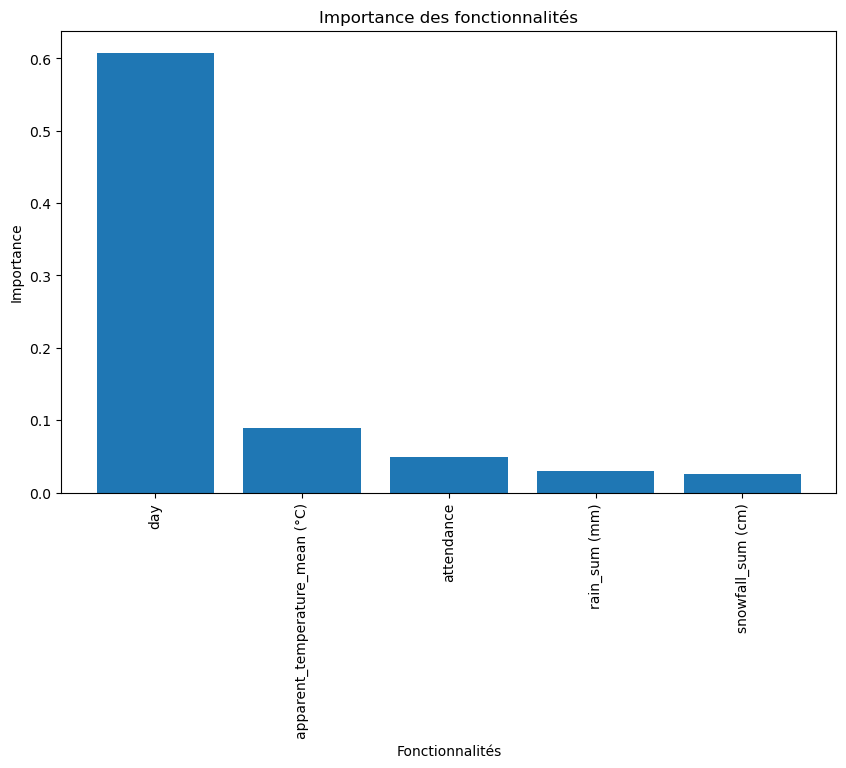

In [5]:
# Obtenir l'importance des fonctionnalités
importance = best_model.feature_importances_
# Triez les fonctionnalités par importance décroissante
feature_names = (X_train.columns).tolist()

# somme l'importance des day_0, day_1, day_2, day_3, day_4, day_5, day_6 en une seule colonne day
importance[4] = importance[4] + importance[5] + importance[6] + importance[7] + importance[8] + importance[9]
importance = np.delete(importance, [5,6,7,8,9,10])
feature_names = np.delete(feature_names, [4,5,6,7,8,9,10])
feature_names = feature_names.tolist()
feature_names.append('day')
feature_names = np.array(feature_names)
indices = np.argsort(importance)[::-1]

# Tracer un graphique de l'importance des fonctionnalités
plt.figure(figsize=(10, 6))
plt.bar(range(len(importance)), importance[indices], tick_label=feature_names[indices].tolist())
plt.xticks(rotation=90)
plt.xlabel('Fonctionnalités')
plt.ylabel('Importance')
plt.title('Importance des fonctionnalités')
plt.show()

On peut voir que la feature jour est la plus importante dans notre modèle. Cela s'explique par le fait que les ventes sont très dépendantes du jour de la semaine. Ensuite les features de la météo sont aussi importantes dans notre modèle. Cela s'explique par le fait que les ventes sont très dépendantes de la météo. Cependant, la feature de l'attendance est relativement inutile. On pourrait croire que les ventes sont très dépendantes de l'attendance des évenements autours de la cage aux sports. On décide de garder cette feature  pour le moment car elle pourrait être utile pour prédire les ventes de la cage aux sports lors d'évenements spéciaux avec plus de données%.

### Comparaison avec les prévisions de planifico 

On compare les prévisions de notre modèle avec les prévisions de planifico sur deux types d'erreur:

* Mean Squared Error (MSE) : Le MSE est une mesure de la moyenne des carrés des différences entre les valeurs prédites et les valeurs réelles. Il calcule la moyenne des écarts quadratiques et pénalise davantage les écarts importants entre les valeurs. Le MSE est utile lorsque les erreurs de prédiction plus importantes doivent être plus fortement pénalisées. Une valeur de MSE plus petite indique une meilleure performance du modèle.

* Mean Absolute Error (MAE) : Le MAE est une mesure de la moyenne des valeurs absolues des différences entre les valeurs prédites et les valeurs réelles. Il calcule la moyenne des écarts absolus et ne pénalise pas autant les erreurs importantes. Le MAE est utile lorsque les erreurs de prédiction doivent être considérées de manière égale, quelle que soit leur magnitude. Une valeur de MAE plus petite indique une meilleure performance du modèle.

Notre prevision --> MSE : 3189.297906559785, MAE  : 2921.788212890625,
Prévision cage --> MSE : 4194.392137211303, MAE : 3096.20875
Notre modèle est meilleur que la prévision de cage


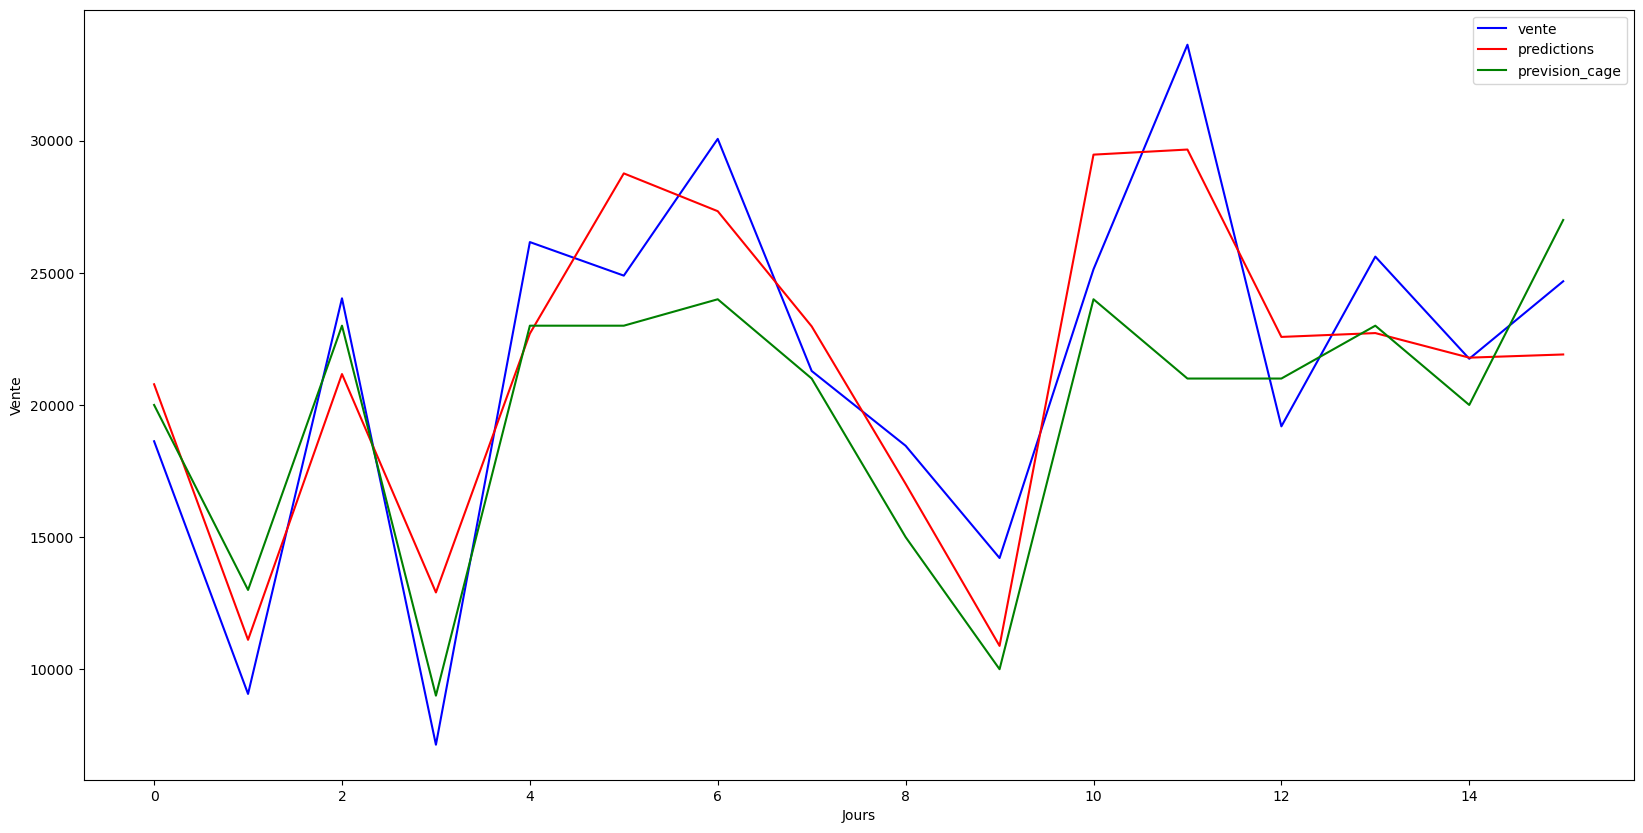

In [6]:
erreur_model,erreur_cage = modele_xg.compare2planifico(best_model,X_test,y_test,prevision_cage,plot = True)

On peut voir que notre modèle est plus performant que les prévisions de planifico par rapoort au MES ce qui montre que notre présente moins d'erreur importante que les prévisions de planifico. Cependant, notre modèle est legerement moins performant que les prévisions de planifico par rapport au MAE ce qui montre que notre modèle présente un peu plus d'erreur en moyenne que les prévisions de planifico. Cela s'explique nottament par le manque de données. En effet, notre modèle est entrainé sur 90 jours de données alors que les prévisions de planifico sont entrainées sur plusieurs années de données. On peut donc s'attendre à ce que notre modèle soit moins performant que les prévisions de planifico.